# Loading annotations

<a target="_blank" href="https://colab.research.google.com/github/pcr-upm/opal23_headpose/blob/main/notebooks/load_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook shows how to load our Panoptic annotations into a PyTorch Dataset class

In [1]:
import os

import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms as T

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

Download annotations file and sample images

In [2]:
!wget -nc https://raw.githubusercontent.com/pcr-upm/opal23_headpose/main/test/panoptic_ann.txt
!wget -nc https://github.com/pcr-upm/opal23_headpose/raw/main/notebooks/sample_images.zip
!unzip -n sample_images.zip -d sample_images

File ‘panoptic_ann.txt’ already there; not retrieving.

File ‘sample_images.zip’ already there; not retrieving.

Archive:  sample_images.zip


Simple PyTorch Dataset class to read annotations

In [3]:
class PanopticDataset(Dataset):
    def __init__(self, data_path, ann_path, bbox_scale=1.0, transform=None):
        super().__init__()

        self.bbox_scale = bbox_scale
        self.transform = transform

        self.data = self._load_ann(data_path, ann_path)


    def _load_ann(self, data_path, ann_path):
        data = []
        with open(ann_path, 'r') as f:
            for line in f.readlines():
                # Skip headers
                if line.startswith('#'):
                    continue

                line = line.strip().split(';')
                # Absolute path to image file
                img_path = os.path.join(data_path, line[0])
                # Face bounding box with format (x, y, w, h)
                bbox = [int(item) for item in line[1:5]]
                # Square bounding box (x, y, side, side)
                bbox = self._square_bbox(bbox)
                # Head pose annotation with format (yaw, pitch, roll)
                headpose = [float(angle) for angle in line[5:8]]
                data.append({
                    'img_path': img_path,
                    'bbox': bbox,
                    'headpose': headpose
                })

        return data

    def _square_bbox(self, bbox):
        x, y, w, h = bbox

        center_x = x + w / 2
        center_y = y + h / 2
        side = max(w, h) * self.bbox_scale
        side_div_2 = side / 2

        new_x = int(center_x - side_div_2)
        new_y = int(center_y - side_div_2)
        side = int(side)

        return [new_x, new_y, side, side]

    def __getitem__(self, index):
        sample = self.data[index]

        # Read and crop image
        img = cv2.imread(sample['img_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        x, y, w, h = sample['bbox']
        img = img.crop((x, y, x + w, y + h))

        if self.transform is not None:
            img = self.transform(img)

        headpose = np.array(sample['headpose'])
        return img, headpose

    def __len__(self):
        return len(self.data)

Show sample images

In [4]:
transform = T.Compose([T.Resize(size=128)])
dataset = PanopticDataset('sample_images', 'panoptic_ann.txt', transform=transform)

In [5]:
# Utility function to draw head pose annotations
# Adapted from https://github.com/natanielruiz/deep-head-pose/blob/f7bbb9981c2953c2eca67748d6492a64c8243946/code/utils.py#L86
def draw_axis(img, rot, tdx=None, tdy=None, size=50, colors=((255, 0, 0), (0, 255, 0), (0, 0, 255))):
    if isinstance(img, Image.Image):
        canvas = np.array(img)
        canvas = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)
    else:
        canvas = img.copy()
    yaw, pitch, roll = rot * np.pi / 180
    height, width = canvas.shape[:2]
    if tdx is None:
        tdx = width / 2
    if tdy is None:
        tdy = height / 2

    x1 = size * (np.cos(yaw) * np.cos(roll)) + tdx
    y1 = size * (np.cos(pitch) * np.sin(roll) + np.cos(roll) * np.sin(pitch) * np.sin(yaw)) + tdy

    x2 = size * (-np.cos(yaw) * np.sin(roll)) + tdx
    y2 = size * (np.cos(pitch) * np.cos(roll) - np.sin(pitch) * np.sin(yaw) * np.sin(roll)) + tdy

    x3 = size * (np.sin(yaw)) + tdx
    y3 = size * (-np.cos(yaw) * np.sin(pitch)) + tdy

    cv2.line(canvas, (int(tdx), int(tdy)), (int(x1), int(y1)), colors[1], 2)
    cv2.line(canvas, (int(tdx), int(tdy)), (int(x2), int(y2)), colors[0], 2)
    cv2.line(canvas, (int(tdx), int(tdy)), (int(x3), int(y3)), colors[2], 2)

    canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    return canvas

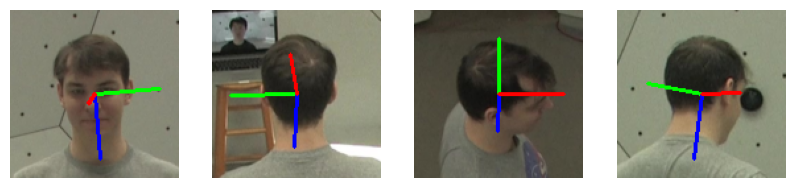

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for idx, axis in enumerate(ax.flat):
    img, headpose = dataset[idx]
    img = draw_axis(img, headpose)
    axis.imshow(img)
    axis.axis('off')
plt.show()